In [1]:
import os

import datetime
import pandas as pd
import numpy as np
from scipy.fft import fft
import string

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.lines as mlines
import seaborn as sns
import skill_metrics as sm
from sklearn.metrics import r2_score

import matplotlib.patches as mpatches

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors  # For RGBA to hex conversion

from src.plots import *
from src.utilities import cal_metrics, mielke_lambda, percentile_mean, fluctuation_frequency
from matplotlib.patches import ConnectionPatch

In [2]:
# Set inputs
TRANSECTS = ['Transect2', 'Transect5', 'Transect8'] # List of transects for evaluation


fp_input = 'datasets/shorelines' # File path for input data
fp_sub = 'submissions/{}' # File path for submission
fp_resub = 'resubmissions/{}' # File path for resubmission

fn_obs = 'shorelines_obs.csv' # File name for observed shoreline
fn_cali = 'shorelines_calibration.csv' # File name for calibration shoreline
fn_targ_short = 'shorelines_hidden_short.csv' # File name for target shoreline (short-term)
fn_targ_medium = 'shorelines_hidden_medium.csv' # File name for target shoreline (medium-term)
fn_pred_short = 'shorelines_prediction_short.csv' # File name for predicted shoreline (short-term)
fn_pred_medium = 'shorelines_prediction_medium.csv' # File name for predicted shoreline (medium-term)
fn_pred_RCP45 = 'shorelines_prediction_long_RCP45.csv' # File name for predicted shoreline (short-term)
fn_pred_RCP85 = 'shorelines_prediction_long_RCP85.csv' # File name for predicted shoreline (medium-term)

sep_time = datetime.datetime(year=1986, month=1, day=1) # Separate medium prediction to two periods

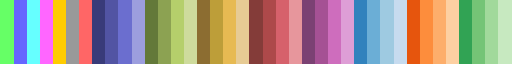

In [3]:
# n_colors = 10

# # Define the colormaps to sample from
# colormap_names = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

# # Create an array to store the colors
# colors = []

# # Sample colors from each colormap
# for cmap_name in colormap_names:
#     cmap = plt.get_cmap(cmap_name, n_colors)
#     colors.extend(cmap(np.linspace(0, 1, n_colors))[2:9])

# # Create a new colormap from the combined colors
# cmap = ListedColormap(colors)
# cmap

# Get the colors from tab20b and tab20c
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')
hsv = plt.get_cmap('hsv')

# Combine the colors
colors_tab20b = tab20b(np.linspace(0, 1, 20))
colors_tab20c = tab20c(np.linspace(0, 1, 20))[:-8, :]
combined_colors = np.vstack((np.array([[0.4, 1, 0.4, 1], [0.4, 0.4, 1, 1], [0.4, 1, 1, 1],
                                      [1, 0.4, 1, 1], [1, 0.8, 0, 1], [0.6, 0.6, 0.6, 1],
                                       [1, 0.4, 0.4, 1]]), 
                             colors_tab20b, colors_tab20c))


# Create a new colormap from the combined colors
cmap = plt.matplotlib.colors.ListedColormap(combined_colors)
cmap

In [4]:
# Read model metadata
df_meta = pd.read_excel('model_summary.xlsx', header=[1])
df_meta = df_meta[~df_meta['Model Name'].str.contains('corrected_JAAA')]
df_meta['Process'] = 'CS_LS'
df_meta.loc[(df_meta['Cross-Shore'].isna())&(~df_meta['Long-Shore'].isna()), 'Process']='LS_Only'
df_meta.loc[(~df_meta['Cross-Shore'].isna())&(df_meta['Long-Shore'].isna()), 'Process']='CS_Only'
#df_meta['Model Name'] = df_meta['Model Name'].str.rsplit('_', n=1, expand=True)[0]


# Define groups of interest
model_groups = {
    'DDM': list(df_meta.loc[df_meta['Type']=='DDM', 'Model Name']),
    'HM': list(df_meta.loc[df_meta['Type']=='HM', 'Model Name']),
    'PBM': list(df_meta.loc[df_meta['Type']=='PBM', 'Model Name']),
    'COCOON': list(df_meta.loc[df_meta['Model Name'].str.contains('COCOON'), 'Model Name']),
    'CoSMoS': list(df_meta.loc[df_meta['Model Name'].str.contains('CoSMoS'), 'Model Name']),
    'LSTM': list(df_meta.loc[df_meta['Model Name'].str.contains('LSTM'), 'Model Name']),
    'ShoreFor': list(df_meta.loc[df_meta['Model Name'].str.contains('ShoreFor'), 'Model Name']),
    'CS_Only': list(df_meta.loc[df_meta['Process']=='CS_Only', 'Model Name']),
    'LS_Only': list(df_meta.loc[df_meta['Process']=='LS_Only', 'Model Name']),
    'CS_LS': list(df_meta.loc[df_meta['Process']=='CS_LS', 'Model Name']),
}

model_names = list(np.unique(df_meta['Model Name'].values))
model_colors = dict(zip(model_names, cmap.colors[0:len(model_names)]))
df_meta['Color'] = df_meta['Model Name'].apply(lambda x: model_colors.get(x))

In [5]:
fn_targs = {'Short':fn_targ_short,
           'Medium (pre-1986)':fn_targ_medium,
           'Medium (post-1986)':fn_targ_medium}
data_ranges = {
    'Short':pd.date_range(start='2019-01-01', end='2023-12-31'),
    'Medium (pre-1986)':pd.date_range(start='1951-06-01', end='1985-12-31'),
    'Medium (post-1986)':pd.date_range(start='1986-01-01', end='1999-02-16')
}

df_loss_all = {}
metrics_final = {}
df_targ_all = {}


MODEL_TYPES = {}
MODEL_COLORS = {}
MODELS = []
for task in fn_targs.keys():
    print(task)
    fn_targ = fn_targs[task]
    fn_pred = fn_targ.replace('hidden', 'prediction')
    # Read obs and calibration shoreline data
    df_targ = pd.read_csv(os.path.join(fp_input, fn_targ), index_col='Datetime')
    df_targ.index = pd.to_datetime(df_targ.index)
    df_targ.sort_index(inplace=True)
    
    if task=='Medium (post-1986)':
        df_targ = df_targ.loc[df_targ.index>=sep_time]
    elif task=='Medium (pre-1986)':
        df_targ = df_targ.loc[df_targ.index<sep_time]
    else:
        df_targ = df_targ

    # Read model calibrations
    dfs_pred = {}
    freqs_pred = {} # This saves the frequency level of preds. High freq preds will be plotted on the bottom.
    for i, row in df_meta.iterrows():
        model = row['Model Name']
        if row['Submission Type'] == 'Submission':
            fp = fp_sub
        else:
            fp = fp_resub
        if os.path.exists(os.path.join(fp.format(model), fn_pred)):
            try:
                df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred), index_col='Datetime')
            except:
                df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred), index_col='datetime')
                df_pred.index.name = 'Datetime'
            df_pred.index = pd.to_datetime(df_pred.index)
            df_pred.sort_index(inplace=True)
            
            if fp == fp_resub:
                model = model + '$^*$'
            
            if not model in MODELS:
                MODELS.append(model)
                MODEL_TYPES[model] = row['Type']
                MODEL_COLORS[model] = row['Color']

            
            if task=='Medium (post-1986)':
                dfs_pred[model] = df_pred.loc[df_pred.index>=sep_time]
            elif task=='Medium (pre-1986)':
                dfs_pred[model] = df_pred.loc[df_pred.index<sep_time]
            else:
                dfs_pred[model] = df_pred
            if task=='Short':
                freqs_pred[model] = df_pred.apply(fluctuation_frequency).median()
            

    # Calculate ensembles
    ensemble_values = []
    index = data_ranges[task]

    for key, df_pred in dfs_pred.items():
        ensemble_values.append(df_pred[TRANSECTS].reindex(index).values) 
    ensemble_values = np.stack(ensemble_values)
    #ensemble_mean = np.mean(ensemble_values, axis=0)
    ensemble_mean = percentile_mean(ensemble_values, 5, 95, axis=0)
    ensemble_median = np.nanmedian(ensemble_values, axis=0)
    ensemble_max = np.nanmax(ensemble_values, axis=0)
    ensemble_min = np.nanmin(ensemble_values, axis=0)
    ensemble_std = np.nanstd(ensemble_values, axis=0)

    dfs_pred['Ensemble'] = pd.DataFrame(ensemble_mean, columns=TRANSECTS, index=index)
    if 'Ensemble' not in MODELS:
        MODELS.append('Ensemble')
    MODEL_TYPES['Ensemble'] = 'ENS'
    MODEL_COLORS['Ensemble'] = 'k'

    # Calculate metrics
    df_loss = pd.DataFrame(columns=TRANSECTS, index=dfs_pred.keys()) # Dataframe to save loss for model and transects
    metrics_all = {}

    for i, tran_id in enumerate(TRANSECTS):
        metrics = {}

        # Calculate metrics for the target
        metrics["Target"] = cal_metrics(df_targ[[tran_id]], df_targ[[tran_id]])
        metrics["Prediction"] = {}
        for model in dfs_pred.keys():
            # Calculate metrics for predictions
            metrics["Prediction"][model] = cal_metrics(df_targ[[tran_id]], dfs_pred[model][[tran_id]])
            df_loss.loc[model, tran_id] = metrics["Prediction"][model]['loss']
        metrics_all[tran_id] = metrics
    
    if task == 'Short':
        # Sort zorder based on freq
        sorted_freq = {k: v for k, v in sorted(freqs_pred.items(), key=lambda item: item[1], reverse=True)}
        zorders = {model: i for i, model in enumerate(sorted_freq.keys(), 1)}
        zorders['Ensemble'] = 51
        zorders['CoSMoS-COAST-CONV_SV'] = 50
        zorders['GAT-LSTM_YM'] = 49
        zorders['iTransformer-KC'] = 48
        
    df_loss_all[task] = df_loss
    metrics_final[task] = metrics_all
    df_targ_all[task] = df_targ

Short
Medium (pre-1986)
Medium (post-1986)


In [6]:
for i, task in enumerate(fn_targs.keys()):
    df_loss = df_loss_all[task].mean(1).to_frame(name=task)
    if i == 0:
        df_loss_merge = df_loss
    else:
        df_loss_merge = df_loss_merge.merge(df_loss, how='outer', left_index=True, right_index=True)
df_loss_merge['Avg'] = df_loss_merge.mean(1)
df_loss_merge['Resubmission'] = df_loss_merge.index.str.contains("*", regex=False)
df_loss_merge= df_loss_merge.sort_values(['Resubmission', 'Avg']).drop(columns=['Resubmission', 'Avg']).round(2)
#df_loss_merge= df_loss_merge.sort_values(['Short']).drop(columns=['Resubmission', 'Avg']).round(2)
df_loss_merge.columns = ['Short', 'Medium\n(<1986)', 'Medium\n(>1986)']
df_loss_merge.index.name = 'Model'
#df_loss_merge = df_loss_merge.transpose()


In [7]:
df_loss_conc = pd.concat(df_loss_all, axis=1)
df_loss_conc['Avg'] = df_loss_conc.mean(1)
df_loss_conc['Resubmission'] = df_loss_conc.index.str.contains("*", regex=False)
df_loss_conc= df_loss_conc.sort_values(['Resubmission', 'Avg']).drop(columns=['Resubmission', 'Avg']).astype('float').round(2)
# df_loss_conc.columns = ['Short', 'Medium\n(<1986)', 'Medium\n(>1986)']
df_loss_conc.index.name = 'Model'
df_loss_conc.to_csv('Figures/model_loss.csv', index_label='Model')

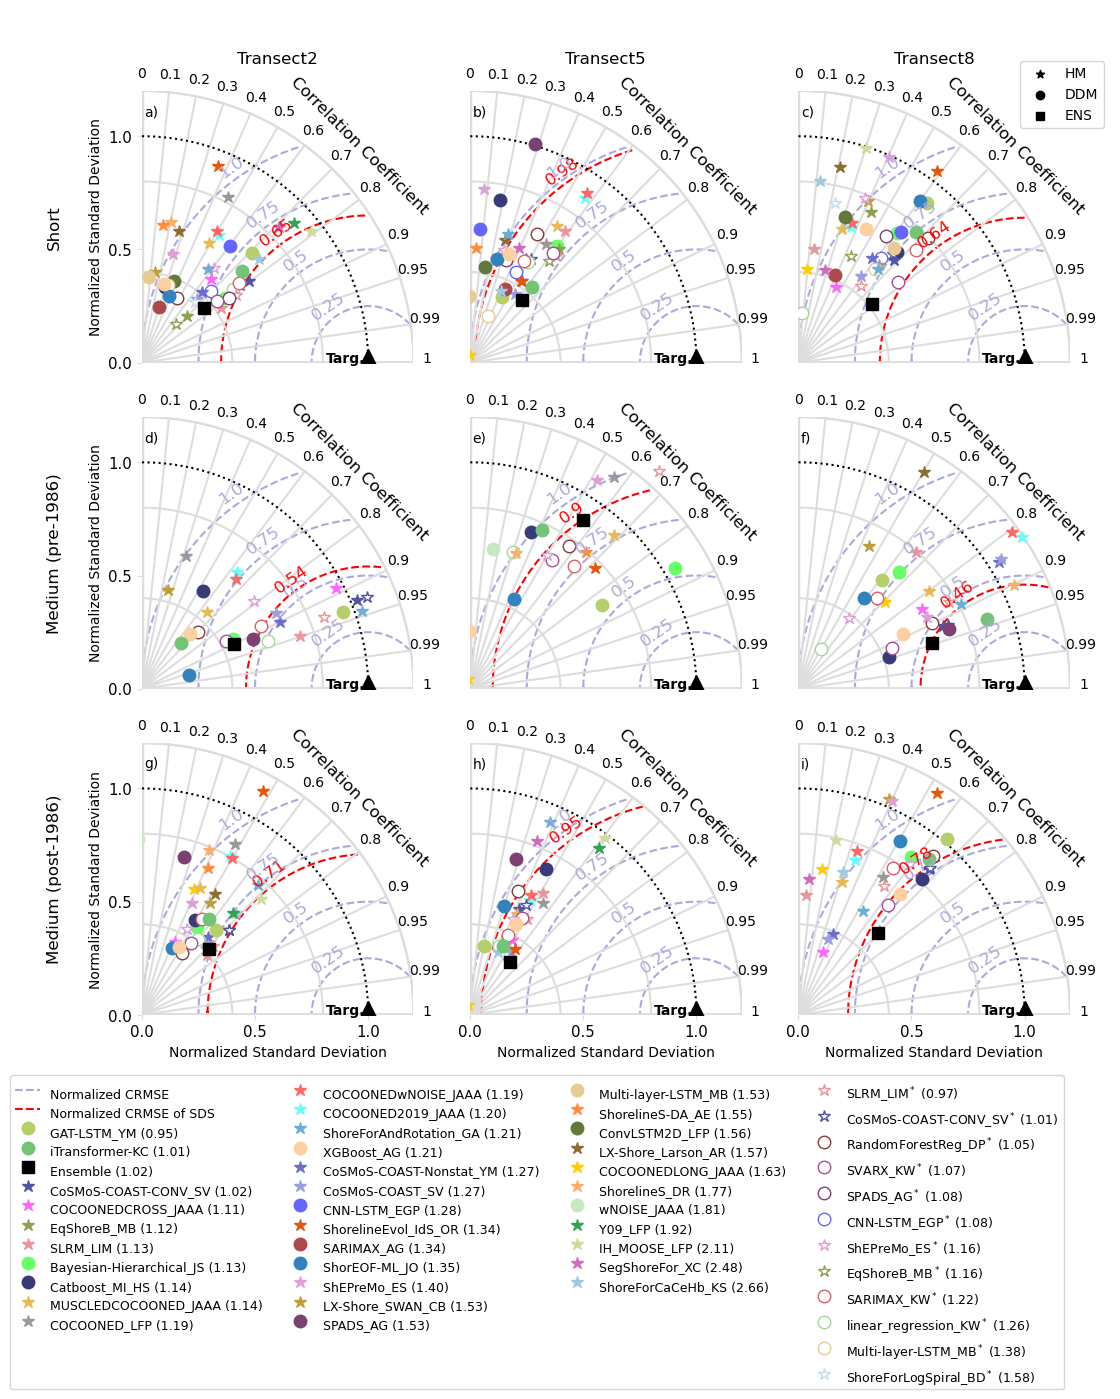

In [11]:
MARKERS = {
'HM': '*',
'DDM':'o',
'ENS': 's',
}
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
letters = string.ascii_lowercase # Letters used to label subplots
count = 0
for j, task in enumerate(fn_targs.keys()):
    for i, tran_id in enumerate(TRANSECTS):
        metrics = metrics_final[task][tran_id]
        df_targ = df_targ_all[task]
        ax = axes[j, i]
        ax.text(0.01,0.95, letters[count] + ')', ha='left',va='top', transform=ax.transAxes, zorder=10)
        count += 1
        ax = plot_taylor(metrics, MODEL_TYPES, MODEL_COLORS, legend=None, ax=ax, 
                         SDS_RMS=round(8.9/df_targ.std()[tran_id], 2))
        
        #ax.set_title('{}: {}'.format(task, tran_id), loc="left", y=1.1, rotation=45)
        if i !=0:
            ax.set_ylabel('')
            ax.set_yticks([])
        if i == 0:
            ax.text(-0.35, 0.5, '{}'.format(task), rotation=90, transform=ax.transAxes,
                    fontsize=12, verticalalignment='center')
        if j!=2:
            ax.set_xlabel('')
            ax.set_xticks([])
        if j == 0:          
            ax.text(0.5, 1.1, '{}'.format(tran_id), transform=ax.transAxes, 
                    fontsize=12, horizontalalignment='center')
            
        if (i==2)&(j==0):
            ax2 = ax.inset_axes([1, 1.15, 0.15, 0.15])
            for key, value in MARKERS.items():
                ax2.scatter([], [], color='k', marker=value, label=key)
                ax2.legend(bbox_to_anchor=[1,-0.1], loc=1, ncol=1)
                ax2.axis('off')
#         if (i==2)&(j==0):
#             ax2 = ax.inset_axes([1, 1.32, 0.15, 0.15])
#             ax2.scatter([], [], color='k', marker='o', facecolor='k', label='Blind')
#             ax2.scatter([], [], color='k', marker='o', facecolor='None', label='Non-blind')
#             ax2.legend(bbox_to_anchor=[1,-0.1], loc=1, ncol=1)
#             ax2.axis('off')


legend_handles = [] 
# Add legend of CRMSE line to handles
legend_handles.append(mlines.Line2D([], [],
                  color='#AAAADD',
                  linestyle='--',
                  label="Normalized CRMSE"))
legend_handles.append(mlines.Line2D([], [],
              color='red',
              linestyle='--',
              label="Normalized CRMSE of SDS"))

for model_id in df_loss_merge.index:
    if '*' in model_id:
        facecolor = 'White'
    else:
        facecolor = MODEL_COLORS[model_id]
    marker = mlines.Line2D([], [], 
                       marker=MARKERS[MODEL_TYPES[model_id]],
                       markersize=9,
                       markerfacecolor=facecolor,
                       markeredgecolor=MODEL_COLORS[model_id],
                       linestyle='None',
                       label='{} ({:.2f})'.format(model_id, df_loss_merge.mean(1)[model_id]))
    legend_handles.append(marker)
    if model_id == 'ShoreForCaCeHb_KS':
        # Append an empty marker to make the legends align better
        legend_handles.append(mlines.Line2D(range(10), range(10), marker='', color="white"))
        #legend_handles.append(mlines.Line2D(range(10), range(10), marker='', color="white"))
    

legend = ax.legend(handles=legend_handles, bbox_to_anchor=[1,-0.2], loc=1, ncol=4, fontsize=9)
for text in legend.get_texts():
    text.set_verticalalignment('center')  # Ensures uniform alignment

# con_line = ConnectionPatch((0.15, -0.65), (0.96, -0.65), coordsA=ax.transAxes, coordsB=ax.transAxes,
#                          linewidth=1, linestyle='--', color='k')
# fig.add_artist(con_line)


plt.savefig('figures/paper/Fig5.jpg', dpi=300, bbox_inches='tight')

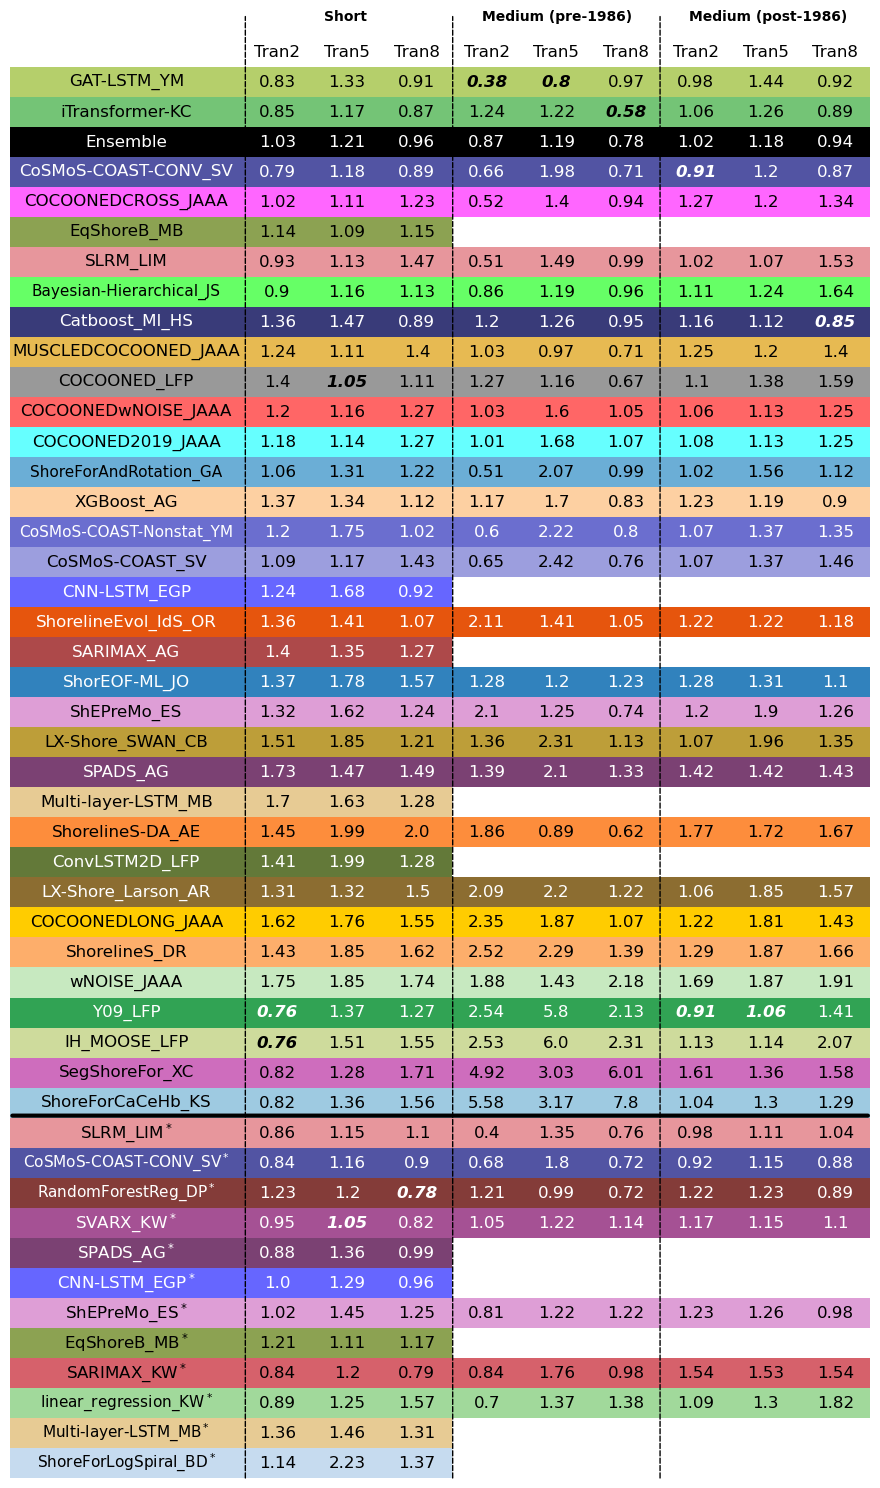

In [19]:
fig, table_ax = plt.subplots(1, 1, figsize=(6, 13))

# Extracting multi-level column headers
col_labels = [""]+['Tran'+col[1][-1] for col in df_loss_conc.columns]

# Prepare the cell text
cell_text = [[index] + list(row) for index, row in zip(df_loss_conc.index, df_loss_conc.values)]
colWidths = [0.5] + [0.15] * len(df_loss_conc.columns)

# Create the table
table = table_ax.table(
    cellText=cell_text,
    colLabels=col_labels,  # Multi-level column headers combined into strings
    cellLoc="center",
    loc="center",
    colWidths=colWidths
)

# Style the table cells
for (i, j), cell in table.get_celld().items():
    cell.set_height(0.03)
    cell.set_linewidth(0)

table.auto_set_font_size(False)
table.set_fontsize(12)

# Minimum values for highlighting
min_values = df_loss_conc.min()


# Add Merged Headers for First-Level Columns
first_level_headers = df_loss_conc.columns.get_level_values(0)
unique_headers = pd.unique(first_level_headers)

# Define Header Start/End Indices
start_idx = 1  # Start after the row index column
header_positions = {header: [] for header in unique_headers}

for idx, header in enumerate(first_level_headers):
    header_positions[header].append(start_idx + idx)
# Add Merged Headers for First-Level Columns
first_level_headers = df_loss_conc.columns.get_level_values(0)
unique_headers = pd.unique(first_level_headers)

# Define Header Start/End Indices
start_idx = 1  # Start after the row index column
header_positions = {header: [] for header in unique_headers}

for idx, header in enumerate(first_level_headers):
    header_positions[header].append(start_idx + idx)
    
# Draw Header Merges
for header, positions in header_positions.items():
    start_col, end_col = positions[0], positions[-1]
    table_ax.text(
        x= (0.27 + 0.28*((start_col + end_col)/2-1))/np.sum(colWidths),
        y=1.24,
        s=header,
        ha="center",
        va="center",
        fontsize=10,
        weight="bold",
        transform = table_ax.transAxes
    )

# Apply colors and styles
for i in range(len(df_loss_conc)):
    for j in range(len(df_loss_conc.columns) + 1):  # Include the index column
        if j == 0:  # Index column
            color = MODEL_COLORS[df_loss_conc.index[i]]
        else:  # Data columns
            color = MODEL_COLORS[df_loss_conc.index[i]]

        cell = table[(i + 1, j)]
        cell.set_facecolor(color)

        # Adjust font color based on cell background
        if type(color) is str:
            color = mcolors.to_rgba(color)  # Convert hex color to RGBA
        effective_luminance = (
            0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
        ) * color[3] + (1 - color[3])
        font_color = "black" if effective_luminance > 0.5 else "white"

        # Bold minimum values
        if j > 0 and df_loss_conc.iloc[i, j - 1] == min_values[j - 1]:  # Skip index column
            cell.set_text_props(weight="extra bold", fontstyle="italic", fontsize=12)

        if j == 0 and len(df_loss_conc.index[i]) > 20:  # Adjust index column font size
            cell.set_text_props(fontsize=11)

        # Apply font properties and handle NaN
        cell.set_text_props(color=font_color)
        if j > 0 and np.isnan(df_loss_conc.iloc[i, j - 1]):  # Skip index column
            cell.set_facecolor("white")
            cell.set_text_props(color="white")

table_ax.axis("off")
grids = np.array([0.15, 0.15+3*0.275, 0.15+6*0.275])/np.sum(colWidths)
for grid in grids:
    con_line = ConnectionPatch((grid, -0.22), (grid, 1.24), coordsA=table_ax.transAxes, coordsB=table_ax.transAxes,
                             linewidth=1, linestyle='--')
    fig.add_artist(con_line)
    
con_line2 = ConnectionPatch((-0.42, 0.142), (1.42, 0.142), coordsA=table_ax.transAxes, coordsB=table_ax.transAxes,
                         linewidth=3, linestyle='-', color='k')
fig.add_artist(con_line2)

plt.savefig('figures/paper/table.jpg', dpi=300, bbox_inches='tight') 

In [10]:
# sorted_columns = {}
# sorted_colors = {}

# for col in df_loss_merge.columns:
#     # Sort values in the column
#     sorted_columns[col] = df_loss_merge[col].sort_values()
#     # Align the corresponding colors with the sorted indices
#     sorted_colors[col] = sorted_columns[col].index.map(MODEL_COLORS)

# fig, table_ax = plt.subplots(1, 1, figsize=(6, 13))

# # Combine the independently sorted columns into a new DataFrame for display
# df_sorted = pd.DataFrame(sorted_columns)

# # Prepare cell content for the table
# cell_text = [[index] + list(row) for index, row in zip(df_sorted.index, df_sorted.values)]

# # Create the table
# table = table_ax.table(
#     cellText=cell_text,
#     colLabels=[""] + list(df_sorted.columns),  # Empty string for the index column header
#     cellLoc="center",
#     loc="center",
#     colWidths=[0.47, 0.15, 0.19, 0.19],
# )

# # Style cells
# for (i, j), cell in table.get_celld().items():
#     cell.set_height(0.03)
#     cell.set_linewidth(0)

# table.auto_set_font_size(False)
# table.set_fontsize(12)

# # Apply colors to cells
# for j, col in enumerate(df_sorted.columns, start=1):  # Start from column 1 (skip index)
#     for i, (model_name, value) in enumerate(sorted_columns[col].items(), start=1):  # Sort order
#         color = MODEL_COLORS[model_name]  # Get color for the model
#         cell = table[(i, j)]
#         cell.set_facecolor(color)

#         # Adjust font color based on cell background luminance
#         if type(color) is str:
#             color = mcolors.to_rgba(color)  # Convert hex color to RGBA
#         effective_luminance = (
#             0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
#         ) * color[3] + (1 - color[3])
#         font_color = "black" if effective_luminance > 0.5 else "white"

#         # Highlight minimum value in bold and italic
#         if value == sorted_columns[col].min():
#             cell.set_text_props(weight="extra bold", fontstyle="italic", fontsize=12)

#         # Apply font color
#         cell.set_text_props(color=font_color)

#         # Hide NaN cells
#         if pd.isna(value):
#             cell.set_facecolor("white")
#             cell.set_text_props(color="white")

# # Ensure the first column (model names) retains its original order and colors
# for i, model_name in enumerate(df_loss_merge.index, start=1):
#     cell = table[(i, 0)]
#     color = MODEL_COLORS[model_name]
#     cell.set_facecolor(color)

#     # Adjust font color for the first column
#     if type(color) is str:
#         color = mcolors.to_rgba(color)
#     effective_luminance = (
#         0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
#     ) * color[3] + (1 - color[3])
#     font_color = "black" if effective_luminance > 0.5 else "white"
#     cell.set_text_props(color=font_color)

# table_ax.axis("off")
# plt.show()